# Converting karst map to a node/link directed graph #

In [1]:
#General imports
import os            
import sys           
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import karstnet as kn

#all fast-marching-related imports
import agd
from agd import Eikonal

#pykasso import
sys.path.append('C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso') #path to local version of package
import base as pk  #in this case, "base" is the name of the .py file with all of the pykasso functions in it

os.getcwd()

'C:\\Users\\Chloe\\Documents\\GitHub\\pyKasso\\notebooks'

icost shape (80, 100, 5)
0 [535.   5.]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
1 [375. 525.]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.009 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
2 [125. 285.]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
3 [145. 585.]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.013

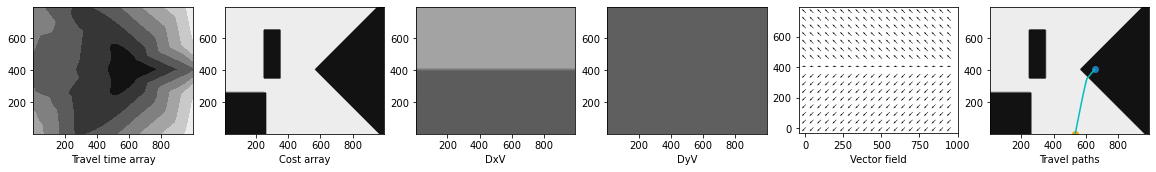

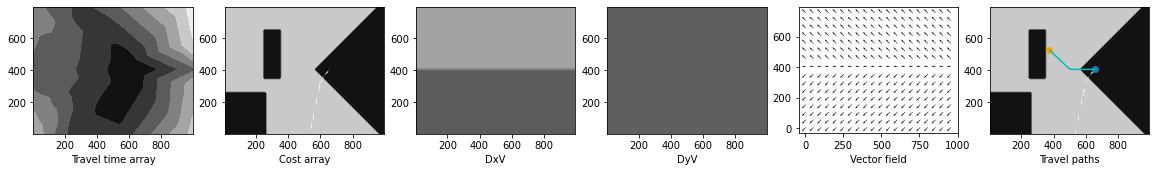

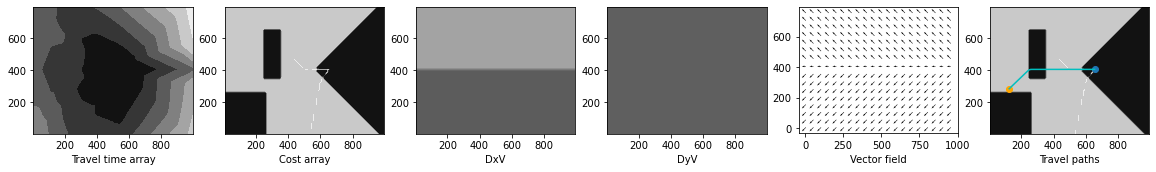

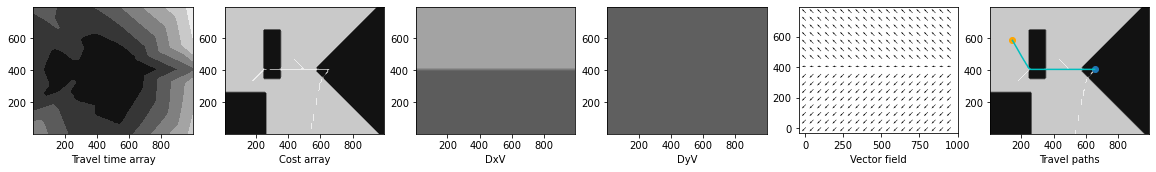

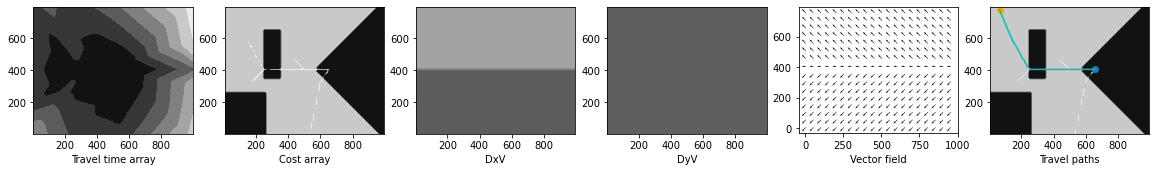

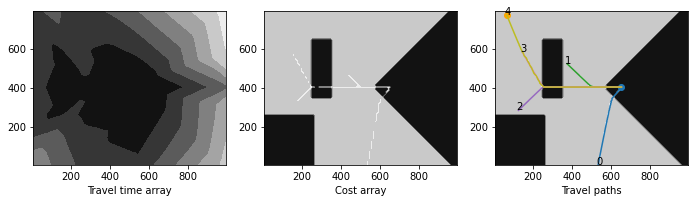

In [2]:
#Run model manually (outside of pykasso but using same steps) to be able to check every step

#THIS IS THE REFERENCE - DO NOT CHANGE

#Load inputs
#Define grid:
xmin = 0;  xmax = 1000;  xres = 100;  dx = 10.0 
ymin = 0;  ymax = 800;   yres = 80;   dy = 10.0 
zmin = 0;  zmax = 600;   zres = 60;   dz = 10.0
hfmIn = agd.Eikonal.dictIn({
    'model':             'Riemann2', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':              2,         #recommended setting: 2
    'exportValues':       1,         #output travel time field
    'exportGeodesicFlow': 1          #output walker paths
})
hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])  #hfm library grid is flipped
X,Y = hfmIn.Grid()  #get model grid
dem = np.genfromtxt("inputs/valley1/dem80x100.csv", delimiter=',')  #2D topography array
geo = np.genfromtxt("inputs/valley1/geo80x100.csv", delimiter=',')  #2D geology array
inlets  = np.genfromtxt("inputs/valley1/inlets.txt",  delimiter=' ')  #import as csv
outlets = np.asarray([np.genfromtxt("inputs/valley1/outlets.txt", delimiter=' ')])  #import as csv - have to wrap in an array if only a single value, otherwise indexing won't work

#Assign cost values
Cout      = 0.999  #travel cost in areas outside model bound (should be very high)
Ckarst    = 0.3    #travel cost in karstifiable unit (should be low)
Cnonkarst = 0.8   #changed to be higher based on Test #3
Cconduit  = 0.1   #travel cost in conduits (should be low)
cost = np.full(geo.shape, Ckarst) #set up array of default alpha values
cost[np.isnan(geo)] = Cout        #assign very high cost to out of bounds
cost[geo==2]        = Ckarst      #assign low cost to limestone (2)
cost[geo!=2]        = Cnonkarst   #assign medium-high cost to all non-karst units

#Run iterations
icost   = np.repeat(cost[:,:,np.newaxis], len(inlets), axis=2)  #repeat cost arrays for each iteration
print('icost shape', icost.shape)
network = []
for i,inlet in enumerate(inlets):
    print(i,inlet)
    # Create a model object and define the domain:
    hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])
    Y,X = hfmIn.Grid()  #get model grid
        
    #Calculate the gradients:
    DxV,DyV = np.gradient(dem,                 dx,dy, axis=(0,1))   #x and y components of gradient in each cell of array
    alpha = icost[:,:,i]                               #travel cost in same direction as gradient
    Cratio = 0.25                       #ratio of travel cost parallel to gradient / perpendicular to gradient
    beta  = alpha / Cratio      #travel cost perpendicular to gradient (should be higher than parallel cost) 
    F = agd.Metrics.Riemann.needle([DxV,DyV], alpha,beta)
    hfmIn['metric'] = F  #set the travel cost through each cell
    hfmIn['seeds']  = outlets[:,[1,0]]    #set the spring coordinates (need to change iteration structure to do one spring at a time)
    hfmIn['tip']    = inlet[[1,0]]    #set the inlet coordinates 

    #Run & get outputs:
    hfmOut = hfmIn.Run()
    time = hfmOut['values']
    paths = hfmOut['geodesics']
    network.append(paths)
    
    #Update cost array to have lower cost in conduits:
    if i < len(inlets)-1:
        for path in paths:                     #loop over paths (if more than one per iteration)
            for p in range(path.shape[1]):     #loop over XYZ coordinates of each point in path (have to index to loop over second dimension)
                point = path[:,p]          
                [[ix,iy],error]  = hfmIn.IndexFromPoint(point) #convert to indices
                icost[ix,iy,i+1:] = Cconduit
    
    #Plot
    f = plt.figure(figsize=(20,5))
    f.add_subplot(161, aspect='equal')
    plt.xlabel('Travel time array')
    plt.contourf(X,Y,time, cmap='gray')
    
    f.add_subplot(162, aspect='equal')
    plt.xlabel('Cost array')
    plt.contourf(X,Y,alpha, cmap='gray_r')
    
    f.add_subplot(163, aspect='equal')
    plt.xlabel('DxV')
    plt.contourf(X,Y, DxV, cmap = 'gray', vmin=-1, vmax=1)
    
    f.add_subplot(164, aspect='equal')
    plt.xlabel('DyV')
    plt.contourf(X,Y, DyV, cmap = 'gray', vmin=-1,vmax=1)
    
    f.add_subplot(165, aspect='equal')
    plt.xlabel('Vector field')
    skip=(slice(None,None,5),slice(None,None,5))
    plt.quiver(X[skip], Y[skip], DyV[skip], DxV[skip], scale=10)
    
    f.add_subplot(166, aspect='equal')
    plt.xlabel('Travel paths')
    plt.contourf(X,Y, alpha, cmap='gray_r')
    plt.scatter(hfmIn['tip'][1],  hfmIn['tip'][0], c='orange')
    plt.scatter(hfmIn['seeds'][:,1], hfmIn['seeds'][:,0])
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[1,:]                               #get list of X coord
        pathY = path[0,:]
        plt.plot(pathX,pathY, c='c')
        
f2 = plt.figure(figsize=(20,5))
f2.add_subplot(151, aspect='equal')
plt.xlabel('Travel time array')
plt.contourf(X,Y,time, cmap='gray')

f2.add_subplot(152, aspect='equal')
plt.xlabel('Cost array')
plt.contourf(X,Y,alpha, cmap='gray_r')

f2.add_subplot(153, aspect='equal')
plt.xlabel('Travel paths')
plt.contourf(X,Y, alpha, cmap='gray_r')
plt.scatter(hfmIn['tips'][:,1],  hfmIn['tips'][:,0], c='orange')
plt.scatter(hfmIn['seeds'][:,1], hfmIn['seeds'][:,0])
for i,inlet in enumerate(inlets):
    plt.annotate(str(i),(inlet[0]-10,inlet[1]))        #label active inlets in order of usage
for p,paths in enumerate(network):
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[1,:]                               #get list of X coord
        pathY = path[0,:]
        plt.plot(pathX,pathY, c=plt.cm.get_cmap('tab10')(p/len(inlets)))

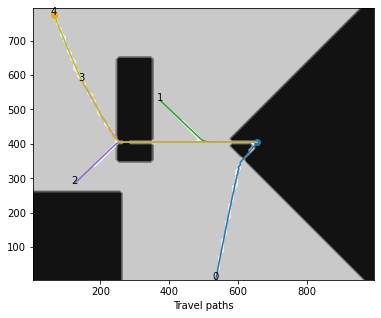

In [21]:
#MAKE CHANGES HERE
verbosity = 0

#Load inputs
#Define grid:
xmin = 0;  xmax = 1000;  xres = 100;  dx = 10.0 
ymin = 0;  ymax = 800;   yres = 80;   dy = 10.0 
zmin = 0;  zmax = 600;   zres = 60;   dz = 10.0
hfmIn = agd.Eikonal.dictIn({
    'model':             'Riemann2', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':              2,         #recommended setting: 2
    'exportValues':       1,         #output travel time field
    'exportGeodesicFlow': 1          #output walker paths
})
hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])  #hfm library grid is flipped
X,Y = hfmIn.Grid()  #get model grid
dem = np.genfromtxt("inputs/valley1/dem80x100.csv", delimiter=',')  #2D topography array
geo = np.genfromtxt("inputs/valley1/geo80x100.csv", delimiter=',')  #2D geology array
inlets  = np.genfromtxt("inputs/valley1/inlets.txt",  delimiter=' ')  #import as csv
outlets = np.asarray([np.genfromtxt("inputs/valley1/outlets.txt", delimiter=' ')])  #import as csv - have to wrap in an array if only a single value, otherwise indexing won't work

#Assign cost values
Cout      = 0.999  #travel cost in areas outside model bound (should be very high)
Ckarst    = 0.3    #travel cost in karstifiable unit (should be low)
Cnonkarst = 0.8   #changed to be higher based on Test #3
Cconduit  = 0.1   #travel cost in conduits (should be low)
cost = np.full(geo.shape, Ckarst) #set up array of default alpha values
cost[np.isnan(geo)] = Cout        #assign very high cost to out of bounds
cost[geo==2]        = Ckarst      #assign low cost to limestone (2)
cost[geo!=2]        = Cnonkarst   #assign medium-high cost to all non-karst units

#Make outlet location map
phi = np.full(geo.shape, np.nan)   #set array full of null values (can't use zeros because first index is zero)
for o, outlet in enumerate(outlets):      #iterate over outlets
    [[ix,iy],error]  = hfmIn.IndexFromPoint(outlet) #convert outlet coordinates to indices
    phi[iy,ix] = o         #set value at outlet locations to outlet index
    
#Make node location map
nodemap = np.full(geo.shape, np.nan)  #set array of null values (can't use zeros because first index is zero)

#Run iterations
icost   = np.repeat(cost[:,:,np.newaxis], len(inlets), axis=2)  #repeat cost arrays for each iteration
network = []   #empty list to store paths from each iteration
nodes   = {}   #empty dic to store nodes
edges   = {}   #empty dic to store edges
n       = 0    #start node counter at zero
e       = 0    #start edge counter at zero
for i,inlet in enumerate(inlets):
    if verbosity > 1:
        print('inlet iteration:', i,inlet)
    if i > 0:    #if not the first iteration
        icost[:,:,i] = icost[:,:,i-1]   #current cost map is cost map from previous iteration
    # Create a model object and define the domain:
    hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])
    Y,X = hfmIn.Grid()  #get model grid
        
    #Calculate the gradients:
    DxV,DyV = np.gradient(dem, dx,dy, axis=(0,1))   #x and y components of gradient in each cell of array
    alpha = icost[:,:,i]                               #travel cost in same direction as gradient
    Cratio = 0.25                       #ratio of travel cost parallel to gradient / perpendicular to gradient
    beta  = alpha / Cratio      #travel cost perpendicular to gradient (should be higher than parallel cost) 
    F = agd.Metrics.Riemann.needle([DxV,DyV], alpha,beta)
    hfmIn['metric'] = F  #set the travel cost through each cell
    hfmIn['seeds']  = outlets[:,[1,0]]    #set the spring coordinates (need to change iteration structure to do one spring at a time)
    hfmIn['tip']    = inlet[[1,0]]    #set the inlet coordinates 
    hfmIn['verbosity'] = 0            #set verbosity to 0 to suppress printing

    #Run & get outputs:
    hfmOut = hfmIn.Run()
    time = hfmOut['values']
    paths = hfmOut['geodesics']
    network.append(paths)
    
    #Plot cost field before it is updated:
    if verbosity > 1:
        f = plt.figure(figsize=(15,15))
        f.add_subplot(111, aspect='equal')
        plt.xlabel('Travel paths')
        plt.contourf(X,Y, icost[:,:,i], cmap='gray_r')
        plt.scatter(hfmIn['tip'][1],  hfmIn['tip'][0], c='orange')
        plt.scatter(hfmIn['seeds'][:,1], hfmIn['seeds'][:,0], c='green')
    
    #Update cost array to have lower cost in conduits, and make nodes/edges list:
    for path in paths:                     #loop over paths (if more than one per iteration)
        #plot paths
        #pathX = path[1,:]                  #get list of X coord
        #pathY = path[0,:]                  #get list of Y coord
        #plt.plot(pathX,pathY, c='c', linewidth=1) #plot path lines
        
        for p in range(path.shape[1]):     #loop over XYZ coordinates of each point in path (have to index to loop over second dimension)
            point = path[:,p]                              #get current point coordinates
            if verbosity > 0:
                print('\t point', p, point)
            [[ix,iy],error]  = hfmIn.IndexFromPoint(point) #convert to indices

            if icost[ix,iy,i] != Cconduit:                 #if there is no conduit here
                if verbosity > 0:
                    print('\t no conduit present')
                if ~np.isnan(phi[ix,iy]):                         #if there is an outlet here (the value in this cell is not nan)
                    if verbosity > 0:
                        print('\t \t arrived at outlet - adding outfall node at outlet coordinates (not point coordinates)')
                    outlet = outlets[int(phi[ix,iy])]                  #get coordinates of the outlet indicated by the index
                    nodes[n] = [outlet[1], outlet[0], 'outfall']    #add an outfall node here
                    #nodes[n] = [outlet[1], outlet[0]]    #add a node here
                    nodemap[ix,iy] = n                            #update nodemap with node index
                    if verbosity > 0:
                        print('\t\t', n, nodes[n])
                    if verbosity > 1:
                        plt.scatter(nodes[n][1], nodes[n][0], color='c')
                    if p > 0:                                 #if this is not the first point in the current path
                        if verbosity > 0:
                            print('\t\t\t path already has a node - adding edge')
                        edges[e] = [n-1, n]         #add an edge connecting the previous node to the current node
                        if verbosity > 0:
                            print('\t\t\t', e, edges[e])
                        if verbosity > 1:
                            plt.plot([nodes[n-1][1], nodes[n][1]],  [nodes[n-1][0], nodes[n][0]], color=plt.cm.get_cmap('cividis_r')((p)/path.shape[1]))
                        e = e+1                                   #increment counter up by one
                    n = n+1                                       #increment counter up by one
                else:                                        #if there is not an outlet here
                    if verbosity > 0:
                        print('\t \t no outlet present - adding junction node')
                    nodes[n] = [point[0], point[1], 'junction']   #add a junction node here
                    #nodes[n] = [point[0], point[1]]   #add a node here
                    nodemap[ix,iy] = n                            #update nodemap with node index
                    if verbosity > 0:
                        print('\t \t', n, nodes[n])
                    if verbosity > 1:
                        plt.scatter(nodes[n][1], nodes[n][0], color=plt.cm.get_cmap('cividis')((p)/path.shape[1]))
                    if p > 0:                                    #if this is not the first point in the current path
                        if verbosity > 0:
                            print('\t\t\t path already has a node - adding edge')
                        edges[e] = [n-1, n]            #add an edge connecting the previous node to the current node
                        if verbosity > 0:
                            print('\t\t\t', e, edges[e])
                        if verbosity > 1:
                            plt.plot([nodes[n-1][1], nodes[n][1]],  [nodes[n-1][0], nodes[n][0]], color=plt.cm.get_cmap('cividis_r')((p)/path.shape[1]))
                        e = e+1                                      #increment counter up by one
                    n = n+1                                          #increment counter up by one
                
            elif ~np.isnan(nodemap[ix,iy]):              #if there is already a node in this cell (the cell is not nan)
                if verbosity > 0:
                    print('\t there is already a node present in this cell')
                n_existing = nodemap[ix,iy]     #get index of node already present in current cell
                if verbosity > 0:
                    print('\t existing node index', n_existing, 'next node index', n)
                if n_existing == n-1:       #if existing node index is only one less than next node to be added index, this is a duplicate node and can be skipped
                    if verbosity > 0:
                        print('\t\t duplicate - skip this point without adding a node or link')
                    pass
                else:                         #if existing node index is >1 less than next node to be added index
                    if verbosity > 0:
                        print('\t\t not duplicate - add a link between most recently added node and existing node and stop iterating over current path')
                    edges[e] = [n-1, n_existing] #add link between most recently added node and existing node in cell
                    if verbosity > 0:
                        print('\t\t', edges[e])
                    if verbosity > 1:
                        plt.plot([nodes[n-1][1], nodes[n_existing][1]],  [nodes[n-1][0], nodes[n_existing][0]], color='r')
                    e = e+1
                    break             #stop iterating over current path
        
            icost[ix,iy,i] = Cconduit                       #update current cost map with conduit
        
f2 = plt.figure(figsize=(20,5))
f2.add_subplot(111, aspect='equal')
plt.xlabel('Travel paths')
plt.contourf(X,Y, alpha, cmap='gray_r')
plt.scatter(hfmIn['tips'][:,1],  hfmIn['tips'][:,0], c='orange')
plt.scatter(hfmIn['seeds'][:,1], hfmIn['seeds'][:,0])
for i,inlet in enumerate(inlets):
    plt.annotate(str(i),(inlet[0]-10,inlet[1]))        #label active inlets in order of usage
for p,paths in enumerate(network):
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[1,:]                               #get list of X coord
        pathY = path[0,:]
        plt.plot(pathX,pathY, c=plt.cm.get_cmap('tab10')(p/len(inlets)))


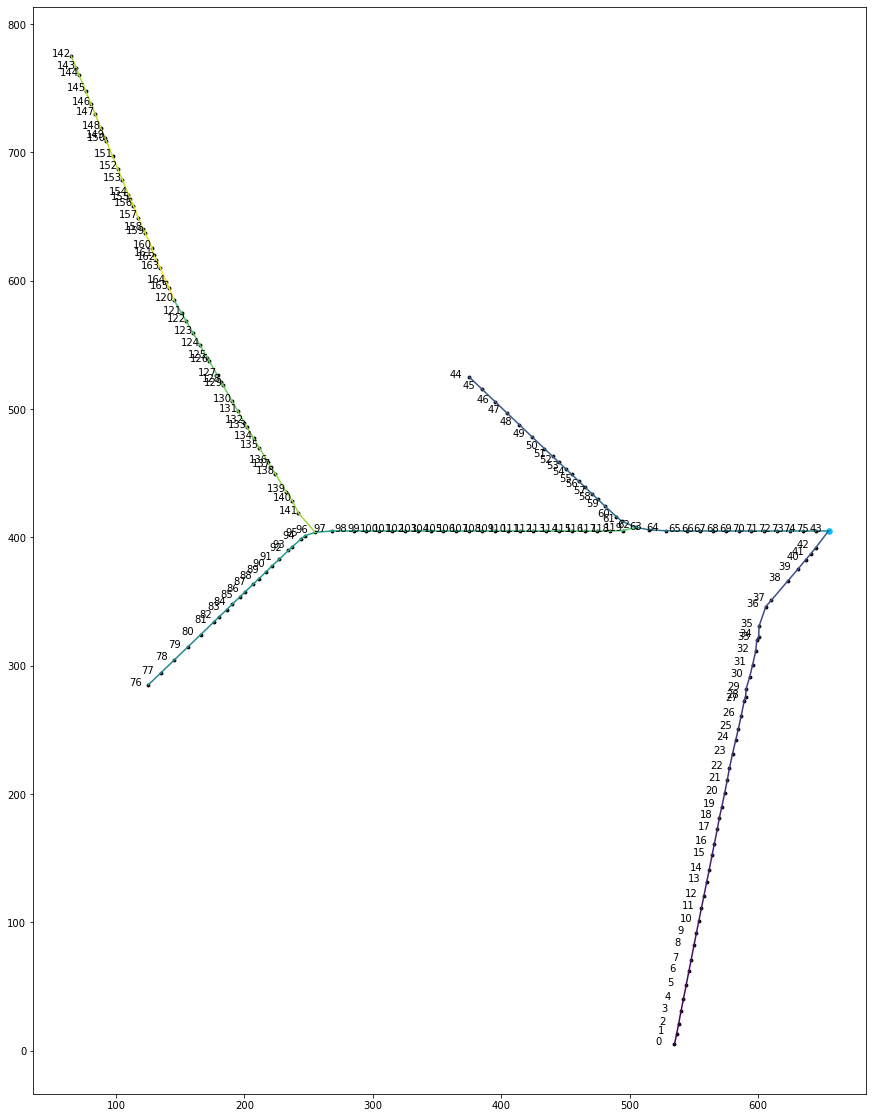

In [22]:
#Plot network using nodes and edges:
nodesdf = pd.DataFrame.from_dict(nodes, orient='index', columns=['X','Y','type'])    #convert to pandas for easier plotting
#nodesdf = pd.DataFrame.from_dict(nodes, orient='index', columns=['X','Y'])    #convert to pandas for easier plotting
edgesdf = pd.DataFrame.from_dict(edges, orient='index', columns=['InNode','OutNode'])

fromX = nodesdf.X.loc[edgesdf.InNode]                  #calculate coordinates for link start and end points
fromY = nodesdf.Y.loc[edgesdf.InNode]
toX   = nodesdf.X.loc[edgesdf.OutNode]
toY   = nodesdf.Y.loc[edgesdf.OutNode]
fig,ax = plt.subplots(figsize=(20,20))
ax.scatter(nodesdf.Y, nodesdf.X, c='k', s=8)   #plot nodes
ax.scatter(nodesdf[nodesdf.type=='outfall'].Y, nodesdf[nodesdf.type=='outfall'].X, c='deepskyblue', s=30)  #plot spring nodes in a dif color
for ind in edgesdf.index:                             #loop over link indices
    ax.plot((fromY.iloc[ind],toY.iloc[ind]),(fromX.iloc[ind],toX.iloc[ind]), c=plt.cm.get_cmap('viridis')(ind/len(edgesdf)))  #plot links
    #ax.annotate(ind, xy=(fromY.iloc[ind]-15, fromX.iloc[ind]))
for ind in nodesdf.index:                         #loop over node indices
    ax.annotate(ind,xy=(nodesdf.Y[ind]-15,nodesdf.X[ind]))     #label nodes with index
    pass
ax.set_aspect('equal')


In [25]:
import copy
nodes2 = copy.deepcopy(nodes)
[value.pop() for key,value in nodes2.items()]
print(nodes2)
print(nodes)

{0: [5.0, 535.0], 1: [13.39269129739474, 536.7527114226193], 2: [20.70723309569429, 538.1819578562723], 3: [30.678730910577766, 540.059681772459], 4: [40.212547555895966, 541.9514736703135], 5: [51.31774621104227, 544.1276229098838], 6: [61.87317399539664, 546.2117239410435], 7: [70.54400730351743, 547.9283646254601], 8: [82.42136808380465, 550.243837466495], 9: [91.582722077951, 552.0395008144995], 10: [101.13887010208443, 553.965407591855], 11: [111.1105227572047, 555.9783705513474], 12: [120.58339733798688, 557.9033072701055], 13: [131.7314575262439, 560.1424188872274], 14: [140.7940364677822, 562.0232904027175], 15: [152.6132622248095, 564.3438234320281], 16: [161.45878016831716, 566.1215381073117], 17: [172.8504004298813, 568.3958118897328], 18: [181.73790058716946, 570.014585527316], 19: [190.06630749627053, 571.8529133680804], 20: [200.46787026747205, 574.0547791747272], 21: [210.7328387685161, 576.1048104643903], 22: [220.0951847970198, 577.8088124548897], 23: [231.399688129637


 This network contains  1  connected components



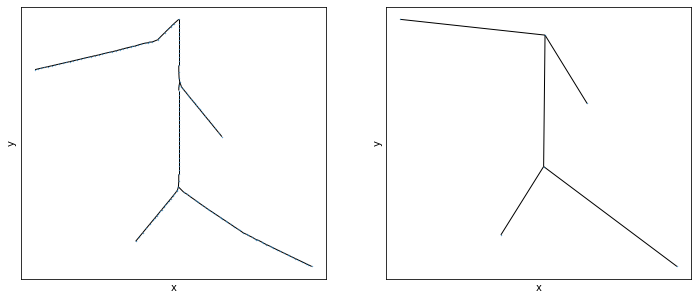

NodeView((0, 62, 44, 96, 76, 142))

In [27]:
#Convert to karstnet graph object:
k = kn.KGraph(list(edges.values()), nodes2)  #note: edges must be a list, and nodes must be a dic with only coord
k.plot()
graph_directed = k.graph_simpl.to_directed()
graph_directed.nodes

#TO-DO:
# flip x,y of node and edge outputs
# convert simple graph to its own indexing
# export complex graph and simple graph as pandas dfs in format needed for SWMM with outfalls identified
# integrate into pyKasso